## Team 14 CSE473s project

In [8]:
import sys
from pathlib import Path

# Add the project root to sys.path dynamically
project_root = Path().resolve().parent  # notebooks/parent = project root
sys.path.append(str(project_root / "lib"))

# imports
import numpy as np
from layers import Dense
from activations import Tanh, Sigmoid, ReLU
from network import NeuralNetwork
from losses import MSE
from optimizer import SGD
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [3]:
import numpy as np

def numerical_gradient_check(model, X, y, loss_fn, epsilon=1e-5):
    # Forward pass
    y_pred = model.forward(X)
    loss = loss_fn.loss(y, y_pred)

    # get analytical gradients
    grad = loss_fn.grad(y, y_pred)
    model.backward(grad)

    # Loop 
    for layer_index, layer in enumerate(model.layers):
        params = layer.params()
   

        print(f"\nChecking layer {layer_index} ({layer.__class__.__name__})")
        
        for (param, grad_param) in params:
         
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])

            while not it.finished:
                idx = it.multi_index
            
                original_value = param[idx]
                
                #  L(W + epsilon)
                param[idx] = original_value + epsilon
                plus_loss = loss_fn.loss(y, model.forward(X))
                
                #  L(W - epsilon)
                param[idx] = original_value - epsilon
                minus_loss = loss_fn.loss(y, model.forward(X))
                
                # Numerical 
                numerical_grad = (plus_loss - minus_loss) / (2 * epsilon)

                param[idx] = original_value
                
                # Analytical 
                analytical_grad = grad_param[idx]
                
                # Compare
                error = abs(numerical_grad - analytical_grad)
                
                #print(f"Param {idx}: numerical={numerical_grad:.7f}, analytical={analytical_grad:.7f}, error={error:.7e}")
                
                it.iternext()


Epoch 1/1000 - loss: 1.417067
Epoch 2/1000 - loss: 1.131942
Epoch 3/1000 - loss: 1.078287
Epoch 4/1000 - loss: 1.046811
Epoch 5/1000 - loss: 1.027114
Epoch 6/1000 - loss: 1.014534
Epoch 7/1000 - loss: 1.005778
Epoch 8/1000 - loss: 0.999550
Epoch 9/1000 - loss: 0.994508
Epoch 10/1000 - loss: 0.990322
Epoch 11/1000 - loss: 0.986447
Epoch 12/1000 - loss: 0.982992
Epoch 13/1000 - loss: 0.979718
Epoch 14/1000 - loss: 0.977134
Epoch 15/1000 - loss: 0.975076
Epoch 16/1000 - loss: 0.974765
Epoch 17/1000 - loss: 0.975543
Epoch 18/1000 - loss: 0.979710
Epoch 19/1000 - loss: 0.983734
Epoch 20/1000 - loss: 0.991425
Epoch 21/1000 - loss: 0.992681
Epoch 22/1000 - loss: 0.997563
Epoch 23/1000 - loss: 0.989316
Epoch 24/1000 - loss: 0.990104
Epoch 25/1000 - loss: 0.973504
Epoch 26/1000 - loss: 0.973477
Epoch 27/1000 - loss: 0.949172
Epoch 28/1000 - loss: 0.950162
Epoch 29/1000 - loss: 0.915838
Epoch 30/1000 - loss: 0.919346
Epoch 31/1000 - loss: 0.871783
Epoch 32/1000 - loss: 0.879668
Epoch 33/1000 - l

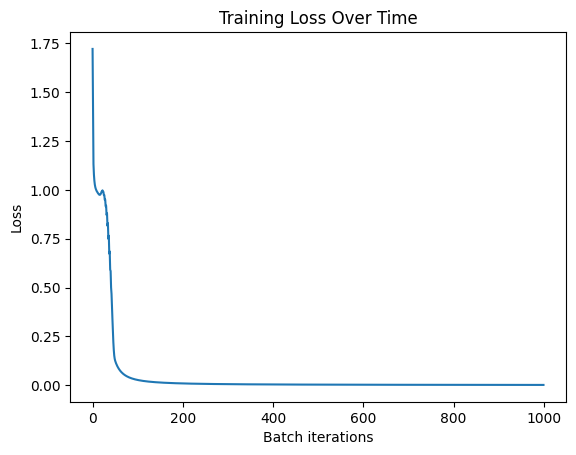

In [4]:
# dataset
X = np.array([[-1,-1],[-1,1],[1,-1],[1,1]], dtype=float)
Y = np.array([[-1],[1],[1],[-1]], dtype=float)

# model: 2 -> 4 -> 1
layers = [
    Dense(2, 4, activation=Sigmoid()),
    Dense(4, 1, activation=Tanh())
]

model = NeuralNetwork(layers, loss_function=MSE())
opt = SGD(lr=0.5)

model.train(X, Y, opt, n_epochs=1000, batch_size=4, verbose=True)
losses = model.get_loss_history()

numerical_gradient_check(model, X, Y, MSE())
print("predictions:", model.predict(X))

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Batch iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

AutoEncoder

In [5]:
from network import NeuralNetwork
from layers import Dense
from activations import ReLU, Sigmoid
from losses import MSE
from optimizer import SGD
import numpy as np
from tensorflow.keras.datasets import mnist

# Load MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize
x_train , x_test = x_train.astype("float32") / 255.0 , x_test.astype("float32") / 255.0


x_train , x_test = x_train.reshape(-1, 784) , x_test.reshape(-1, 784)
  

encoder_layers = [
    Dense(784, 128, activation=ReLU()),
    Dense(128, 64, activation=ReLU()),
    Dense(64, 32, activation=ReLU())
]
encoder_model = NeuralNetwork(encoder_layers, loss_function=MSE())

decoder_layers = [
    Dense(32, 64, activation=ReLU()),
    Dense(64, 128, activation=ReLU()),
    Dense(128, 784, activation=Sigmoid())
]
decoder_model = NeuralNetwork(decoder_layers, loss_function=MSE())

# Autoencoder class
class Autoencoder:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        self.layers = encoder.layers + decoder.layers

    def forward(self, x):
        z = self.encoder.forward(x)
        out = self.decoder.forward(z)
        return out

    def backward(self, dL_dA):
        grad = dL_dA
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad  



ae = Autoencoder(encoder_model, decoder_model)
loss_fn = MSE()
opt = SGD(lr=0.001)

def train_autoencoder(ae, X_train, X_val, epochs=150, batch_size=256):
    n = X_train.shape[0]
    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, epochs+1):
        idx = np.random.permutation(n)
        X_train = X_train[idx]

        epoch_train_loss = 0

        for i in range(0, n, batch_size):
            xb = X_train[i:i+batch_size]

            # Forward pass
            y_pred = ae.forward(xb)

            # Compute loss
            loss = loss_fn.loss(xb, y_pred)
            epoch_train_loss += loss * len(xb)

            # Backward pass
            grad = loss_fn.grad(xb, y_pred)
            ae.backward(grad)

            # Update weights
            opt.step(ae.layers)

        # Average training loss for this epoch
        avg_train_loss = epoch_train_loss / n
        train_loss_history.append(avg_train_loss)

        # Validation loss on full validation set
        y_val_pred = ae.forward(X_val)
        val_loss = loss_fn.loss(X_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}/{epochs}  Train Loss={avg_train_loss:.6f}  Val Loss={val_loss:.6f}")

    return train_loss_history, val_loss_history

# Train using x_train and x_test as validation
train_losses, val_losses = train_autoencoder(ae, x_train, x_test)


Epoch 1/150  Train Loss=0.160889  Val Loss=0.080275
Epoch 2/150  Train Loss=0.076799  Val Loss=0.074194
Epoch 3/150  Train Loss=0.070808  Val Loss=0.069084
Epoch 4/150  Train Loss=0.066898  Val Loss=0.065088
Epoch 5/150  Train Loss=0.063784  Val Loss=0.062739
Epoch 6/150  Train Loss=0.061402  Val Loss=0.059983
Epoch 7/150  Train Loss=0.058685  Val Loss=0.057664
Epoch 8/150  Train Loss=0.056460  Val Loss=0.055511
Epoch 9/150  Train Loss=0.054471  Val Loss=0.053466
Epoch 10/150  Train Loss=0.052786  Val Loss=0.051875
Epoch 11/150  Train Loss=0.051362  Val Loss=0.050495
Epoch 12/150  Train Loss=0.050042  Val Loss=0.049503
Epoch 13/150  Train Loss=0.048866  Val Loss=0.048161
Epoch 14/150  Train Loss=0.047773  Val Loss=0.047117
Epoch 15/150  Train Loss=0.046830  Val Loss=0.046661
Epoch 16/150  Train Loss=0.046002  Val Loss=0.045526
Epoch 17/150  Train Loss=0.045202  Val Loss=0.044974
Epoch 18/150  Train Loss=0.044486  Val Loss=0.044889
Epoch 19/150  Train Loss=0.043863  Val Loss=0.043232
Ep

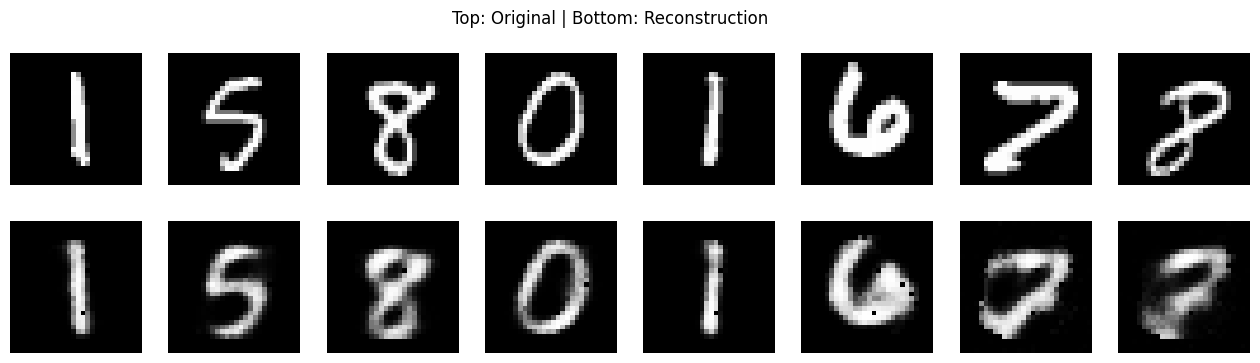

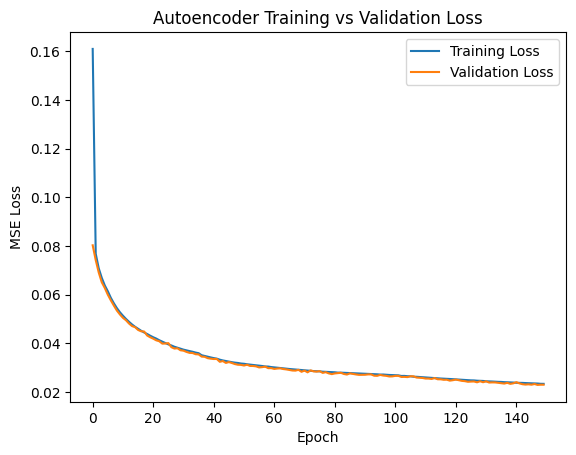

In [6]:
import matplotlib.pyplot as plt
# show some test images and their reconstructions
idxs = np.random.choice(len(x_test), 8, replace=False)
orig = x_test[idxs]
recon = ae.forward(orig)
fig, axs = plt.subplots(2,8, figsize=(16,4))
for i in range(8):
    axs[0,i].imshow(orig[i].reshape(28,28), cmap='gray')
    axs[0,i].axis('off')
    axs[1,i].imshow(recon[i].reshape(28,28), cmap='gray')
    axs[1,i].axis('off')
plt.suptitle('Top: Original | Bottom: Reconstruction')
plt.show()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training vs Validation Loss")
plt.legend()
plt.show()


latent feature extraction


In [7]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist

# -------------------------------------------------------------
# 1. Load MNIST (TensorFlow)
# -------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten and normalize
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28*28).astype("float32") / 255.0

print("MNIST loaded:", x_train.shape, x_test.shape)



print("Encoding latent space...")
latent_train = encoder_model.forward(x_train)
latent_test  = encoder_model.forward(x_test)

print("Latent shapes:", latent_train.shape, latent_test.shape)

# -------------------------------------------------------------
# 3. Train SVM on the latent vectors
# -------------------------------------------------------------
clf = SVC(kernel="rbf", gamma="scale")
clf.fit(latent_train, y_train)

# -------------------------------------------------------------
# 4. Test accuracy
# -------------------------------------------------------------
y_pred = clf.predict(latent_test)

acc = accuracy_score(y_test, y_pred)
print("\nSVM Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


MNIST loaded: (60000, 784) (10000, 784)
Encoding latent space...
Latent shapes: (60000, 32) (10000, 32)

SVM Accuracy: 0.9358

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.92      0.91      0.92      1010
           4       0.92      0.93      0.92       982
           5       0.92      0.92      0.92       892
           6       0.95      0.96      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.92      0.90      0.91       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.93      0.94      0.93     10000
weighted avg       0.94      0.94      0.94     10000


Confusion Matrix:
[[ 954    0    3    3    1    5   12    1    1    0]
 [   0 1121    3   

TensorFlow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float32)

y = np.array([[0], [1], [1], [0]], dtype=np.float32)

model = keras.Sequential([
    layers.Dense(8, activation="relu", input_shape=(2,)),
    layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss="mse"
)

# -------------------------------------------------
# 4. Train Model
# -------------------------------------------------
history = model.fit(
    X, y,
    epochs=3000,
    batch_size=4,
    verbose=0
)


final_loss = history.history["loss"][-1]
print(f"Final training loss (MSE): {final_loss:.6f}")

# -------------------------------------------------
# 6. Evaluate Predictions
# -------------------------------------------------
pred = model.predict(X)

print("\nPredictions:")
print(pred)

print("\nRounded predictions:")
print((pred > 0.5).astype(int))

# -------------------------------------------------
# 7. Plot Training Loss
# -------------------------------------------------
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("XOR Training with MSE + SGD")
plt.grid(True)
plt.show()


In [ ]:


# Load MNIST
(x_train, _), (x_test, _) = mnist.load_data()


# change datatype to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scale the dataset from 0->255 to 0->1
x_train /= 255.0
x_test /= 255.0

# flatten the 28x28 images into vectors of size 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

In [ ]:
print(x_train[:5])

In [ ]:
# create the autoencoder model
def model_fn():
    model_input = tf.keras.layers.Input(shape=(784,))

    # Encoder part (decreasing number of units)
    encoded = tf.keras.layers.Dense(units=512, activation='relu')(model_input)
    encoded = tf.keras.layers.Dense(units=128, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(units=64, activation='relu')(encoded)
    latent_vector= tf.keras.layers.Dense(units=32, name="latent_vector")(encoded) # Latent Space

    # Decoder part (increasing number of units, symmetric to encoder)
    decoded = tf.keras.layers.Dense(units=32, activation='relu')(latent_vector)
    decoded = tf.keras.layers.Dense(units=64, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(units=128, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(units=512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(units=784,activation='sigmoid')(decoded) # Output layer

    # the autoencoder model
    autoencoder_model = tf.keras.Model(inputs=model_input, outputs=decoded_output)

    # compile the model
    autoencoder_model.compile(
        optimizer= tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),
        loss='MSE',
    )
    return autoencoder_model


# build the model
autoencoder_model = model_fn()

# print autoencoder model summary
autoencoder_model.summary()

In [ ]:
# train the model
# Using a reduced number of epochs for demonstration (original was 1000)
autoencoder_history=autoencoder_model.fit(x_train, x_train,
                      epochs=150, # Reduced for time/resource
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test, x_test))

In [ ]:
# visualize reconstruction
sample_size = 6
test_image = x_test[:sample_size]

# reconstruct test samples
test_reconstruction = autoencoder_model.predict(test_image)

plt.figure(figsize=(8, 25))
plt.suptitle('Stacked Autoencoder Reconstruction', fontsize=16)

for i in range(sample_size):
    # Original image
    plt.subplot(sample_size, 2, i*2 + 1)
    plt.title('Original image')
    plt.imshow(test_image[i].reshape((28, 28)), cmap="Greys",
               interpolation="nearest", aspect='auto')

    # Reconstructed image
    plt.subplot(sample_size, 2, i*2 + 2)
    plt.title('Reconstructed image')
    plt.imshow(test_reconstruction[i].reshape((28, 28)), cmap="Greys",
               interpolation="nearest", aspect='auto')

plt.show()


In [ ]:
# Visualization
# Visulaizing the loss
train_loss = autoencoder_history.history['loss']
validation_loss = autoencoder_history.history['val_loss']
epochs = range(len(train_loss))

plt.plot(epochs, train_loss , 'r', label="training loss")
plt.plot(epochs, validation_loss, 'b', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# Latent Space Extraction
encoder = tf.keras.Model(
    inputs=autoencoder_model.input,
    outputs=autoencoder_model.get_layer("latent_vector").output
)

x_train_latent = encoder.predict(x_train)
x_test_latent  = encoder.predict(x_test)

(_, y_train_latent), (_, y_test_latent) = tf.keras.datasets.mnist.load_data()



print(x_train_latent.shape)  # (60000, 32)



In [ ]:
import tensorflow as tf
from tensorflow import keras as ks

### Model Definition ###
# hyperparameters
learning_rate = 0.01
training_epochs = 100
display_step = 50  # print loss after 50 epochs

# Initialization
n_samples = x_train_latent.shape[0]
batch_size = 50
total_batch = int(n_samples / batch_size)

n_input_features = x_train_latent.shape[1]  # size of data input (# size of each element of x), should be 32
n_classes = 10  # number of classes, MNIST has 10 classes (0-9)

# Build the model using tf.keras layers
MCSVM_model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        n_classes,
        activation='linear',  # Use 'linear' for SVM
        input_shape=(n_input_features,)
    )
])

# Custom multi-class hinge loss function
def multiclass_hinge_loss(y_true, y_pred):
    # Cast y_true to an integer type (e.g., tf.int32) before passing to tf.one_hot
    y_true_int = tf.cast(y_true, tf.int32)
    y_true_onehot = tf.one_hot(y_true_int, depth=n_classes)
    correct_class_score = tf.reduce_sum(y_pred * y_true_onehot, axis=1, keepdims=True)
    margins = tf.maximum(0.0, y_pred - correct_class_score + 1.0)
    margins = margins - tf.multiply(margins, y_true_onehot)  # zero out correct class
    return tf.reduce_mean(tf.reduce_sum(margins, axis=1))

# Define optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# Compile the model
MCSVM_model.compile(
    optimizer=optimizer,
    loss=multiclass_hinge_loss,  # Use custom hinge loss
    metrics=['accuracy']
)

# Train the model
history = MCSVM_model.fit(
    x_train_latent, y_train_latent,
    epochs=training_epochs,
    batch_size=batch_size,
    verbose=1,  # Print progress
    callbacks=[ks.callbacks.EarlyStopping(min_delta=0.01, patience=20)]
)

# After training, predict using the model
y_predicted = MCSVM_model.predict(x_test_latent)  # Use .predict() for prediction

# Model summary
MCSVM_model.summary()

# Evaluate the model on the training set
train_loss, train_accuracy = MCSVM_model.evaluate(x_train_latent, y_train_latent, verbose=0)
print("Training Loss: ", train_loss)


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist

# Convert y_predicted from continuous scores to discrete class labels
y_predicted_labels = np.argmax(y_predicted, axis=1)

acc = accuracy_score(y_test_latent, y_predicted_labels)
print("\nSVM Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test_latent, y_predicted_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_latent, y_predicted_labels))
